# Machine learning project - **estimating cloud base height**

**Winter School Machine Learning**<br>
February 2022 - University of Bern

Problem: Instruments to accurately measure the cloud base height (important for aviatic sector) from the ground (so-called **Ceilometer**) are extremly expensive. A cheapter solution are upward facing **thermal cameras**. The temperature measured decreases significantly if a cloud is presence; the higher the cloud, the lower the measured temperature (due to temperature decrease of atmosphere with height). However, the thermal camera does not apply a correction for the atmospheric water vapour between the ground and the cloud measured. Thus, the relation between the measured temperature and the cloud base height is complex. 

In this project, we propose to use parallel measurements from a Ceilometer and a thermal camera (together with standard meteorlogical measurements, such s surface pressure, humditiy, temperature) to develop a Neural Network (NN) to solve the regression probelm. The data are the following:
*   Input (5 dim): 
  * mean temperature measured by upward facing thermal camera
  * max(tempearture) - min(temperature) measrued by upward facing thermal camera
  * surface temperature
  * surface pressure
  * surface humidity
*   Output (1): estimate of cloud base height
* Label (1): cloud base height measured by ceilometer

**Remark:** The data sets are far too small to properly train a NN. However, this is an exercise in the framwork of the Winter School Machine Learning from the University of Bern and serves the solely an educational purpose. 





## Load modules

In [ ]:
colab = True # set to True is using google colab
if colab:
    %tensorflow_version 2.x

# load modules
import os
import sys
import tarfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
%load_ext tensorboard

import pandas as pd

from datetime import date

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Read preprocessed data

#### load google drive and read data

In [ ]:
# load google drive
from google.colab import drive
drive.mount('/content/drive/')

# read file
path = '/content/drive/MyDrive/ML_project/data_prep_all_category.csv'
df = pd.read_csv(path)

# check df
print(df.head())
print(df.shape)
print(df.columns)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
   Unnamed: 0             datetime       mean        min        max      diff  \
0         104  2021-12-18 09:20:00 -63.322591 -67.479661 -58.694501  8.785160   
1         105  2021-12-18 09:30:00 -61.625693 -65.367899 -56.691073  8.676826   
2         106  2021-12-18 09:40:00 -61.750185 -65.105527 -56.818425  8.287103   
3         107  2021-12-18 09:50:00 -61.614325 -65.631848 -57.404920  8.226928   
4         110  2021-12-18 10:20:00 -66.347423 -70.633398 -61.184331  9.449067   

   atmospheric pressure QNH  Relative humidity  Air temperature  Cloud Height  \
0                       968               90.5              0.0         99999   
1                       968               90.4              0.2         99999   
2                       968               88.8              0.6         99999   
3                       967               87.2            

#### Replace "dummy" altitudes for cloud-free conditions
Data points with cloud free conditions have no meaningful cloud heights (label). In the data set the cloud height is set to 99'999 for these cases. We replace these values with -1, such that they are closer to the actual/valid cloud heights from the time steps with clouds. 



In [ ]:
# check current values of Cloud Height for category "cloud free"
print('initial values: ', np.unique(df['Cloud Height'][df['category']==0]))

# replace values 
#df['Cloud Height'][df['category']==0] = -1
df.loc[df['category']==0, 'Cloud Height']  = -1

# check if replacement was successful
print('updated values: ', np.unique(df['Cloud Height'][df['category']==0]))

initial values:  [99999]
updated values:  [-1]


#### Visualize data

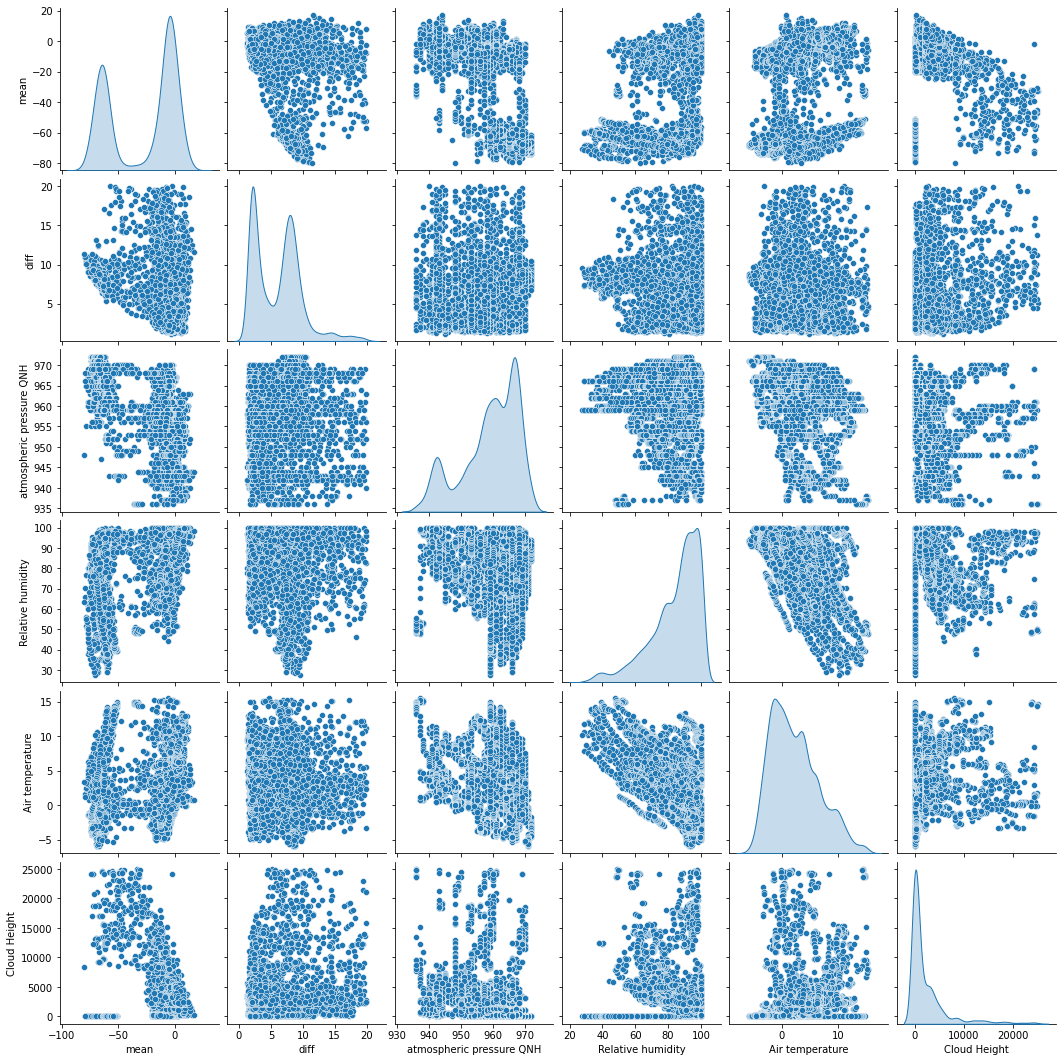

In [ ]:
# inspect data
sns.pairplot(df[['mean', 'diff', 'atmospheric pressure QNH', 'Relative humidity', 'Air temperature', 'Cloud Height']], diag_kind='kde')

## Split data into training and test data set

#### perform split

In [ ]:
# get columns with data as numpy
x_all = df[['mean', 'diff', 'atmospheric pressure QNH', 'Relative humidity', 'Air temperature']].to_numpy() #input (FLIR and surface meteo station)
y_all = df['Cloud Height'].to_numpy() #label (cloud height from Ceilometer) 
n_all = df.shape[0] #size of full data set
n_input = x_all.shape[1]

print('data set of size: ', n_all)
print('shape of input:  ', x_all.shape)
print('shape of labels: ', y_all.shape)

# randomize order and get 80% for training
idx = np.random.permutation(n_all)
n_train = n_all * 80 // 100

idx_train = idx[0:n_train]
idx_val = idx[n_train:]

x_train = x_all[idx_train]
y_train = y_all[idx_train]
print('\nshape x train: ', x_train.shape)
print('shape y train: ', y_train.shape)

x_val = x_all[idx_val]
y_val = y_all[idx_val]
print('\nshape x validate: ', x_val.shape)
print('shape y validate: ', y_val.shape)

# look at first n entries to check whether data split worked properly
print('\n check splitting: ')
for i in range(n_input):
  print(x_train[:5,i])
  print(y_train[:5])

data set of size:  6154
shape of input:   (6154, 5)
shape of labels:  (6154,)

shape x train:  (4923, 5)
shape y train:  (4923,)

shape x validate:  (1231, 5)
shape y validate:  (1231,)

 check splitting: 
[-13.22594432   0.66417451 -73.16265286 -10.70442141 -65.31881661]
[4100  300   -1  900   -1]
[6.05496286 5.56031019 9.32381372 6.91396923 8.13243732]
[4100  300   -1  900   -1]
[952. 944. 965. 959. 972.]
[4100  300   -1  900   -1]
[ 78.5 100.   72.4  86.6  89.2]
[4100  300   -1  900   -1]
[ 3.6  5.4  3.6 -2.6 -3.9]
[4100  300   -1  900   -1]


#### visualize split


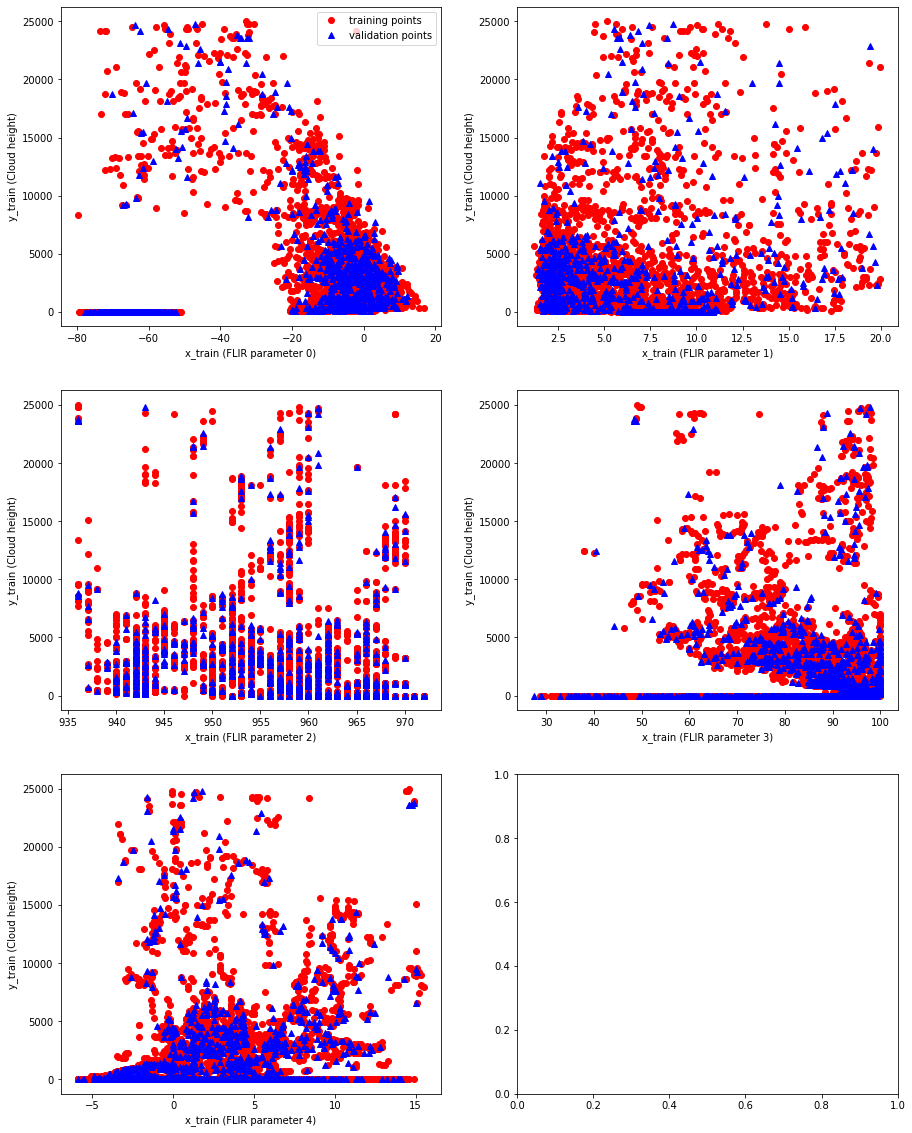

In [ ]:
# plot data
fig,ax = plt.subplots(3, 2, figsize=(15,20))
idx_i = [0,0,1,1,2,2]
idx_j = [0,1,0,1,0,1]

for k in range(n_input):  
#for i,j,k in zip([0,0,1,1,2],[0,1,0,1,0],range(5)):  #(n_input = 5)
  i,j = idx_i[k],idx_j[k]
  #print(i,j,k)
  ax[i,j].plot(x_train[:,k],y_train, "or", x_val[:,k], y_val, "b^")
  ax[i,j].set_xlabel('x_train (FLIR parameter '+str(k)+')')
  ax[i,j].set_ylabel('y_train (Cloud height)')
  #ax[i,j].set_ylim(0,2000)
ax[0,0].legend(('training points', 'validation points'))

### save split as .csv 
Store created training and test data set, such that we can always use the same data sets for the model training at any time.

In [ ]:
np.savetxt('/content/drive/MyDrive/ML_project/regression_x_train_'+date.today().strftime('%Y%m%d')+'.csv', x_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML_project/regression_y_train_'+date.today().strftime('%Y%m%d')+'.csv', y_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML_project/regression_x_val_'+date.today().strftime('%Y%m%d')+'.csv', x_val, delimiter=',')
np.savetxt('/content/drive/MyDrive/ML_project/regression_y_val_'+date.today().strftime('%Y%m%d')+'.csv', y_val, delimiter=',')

## Load test and training data set
Start and proceed from here for continuation of model training ...

In [ ]:
version = '20220304'
x_train = np.loadtxt('/content/drive/MyDrive/ML_project/regression_x_train_'+version+'.csv', delimiter=',')
y_train = np.loadtxt('/content/drive/MyDrive/ML_project/regression_y_train_'+version+'.csv', delimiter=',')
x_val = np.loadtxt('/content/drive/MyDrive/ML_project/regression_x_val_'+version+'.csv', delimiter=',')
y_val = np.loadtxt('/content/drive/MyDrive/ML_project/regression_y_val_'+version+'.csv', delimiter=',')

## Create model
Activation function for regression problem: **ReLu** (values between 0 and infinity)

See also:
* https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
* https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

model with input of shape: 5 and output of shape: 1
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 5)]               0         
                                                                 
 L1 (Dense)                  (None, 128)               768       
                                                                 
 L2 (Dense)                  (None, 128)               16512     
                                                                 
 pred (Dense)                (None, 1)                 129       
                                                                 
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


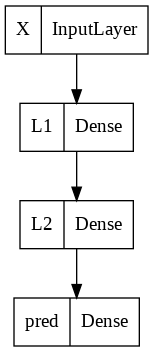

In [ ]:
# size of input and output
n_input = x_train.shape[1]
n_output = 1
print('model with input of shape: '+str(n_input)+' and output of shape: '+str(n_output))

# input layer
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input])

# layer 1
l1 = tf.keras.layers.Dense(units=128, name='L1', activation='relu')(x)

# layer 2
l2 = tf.keras.layers.Dense(units=128, name='L2', activation='relu')(l1)

# output layer 
pred = tf.keras.layers.Dense(units=n_output, name='pred', activation='relu')(l2)

# model
model = tf.keras.Model(inputs=x, outputs=[pred])

# complie model
model.compile()

# print model summary
model.summary()
#print(model.trainable_variables)

# print model graph
tf.keras.utils.plot_model(model)

## Train/fit model
*   Loss function: **mean squared error**
*   Optimizer: **Adam**

Option 1: fixed learning rate

In [ ]:
learning_rate = 0.001 #0.1, 0.01, 0.001, 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Testing learning rates 0.01, 0.001, 0.0001 over 500 epochs:
* 0.0001 seems too small
* 0.001 ok; but rather slow during first ~250 epochs
* 0.01 good choice for first ~100 epochs
Thus, optimally use adaptive learning rate (see option 2)



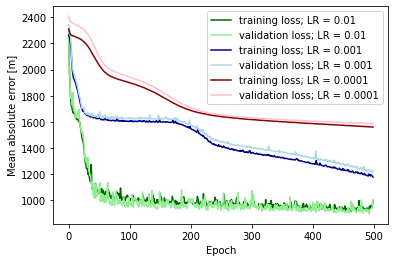

Option 2: learning rate that adapts after n batches

work in progress ...

In [ ]:
# exponentially decaying learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

##### Training loops


In [ ]:
# set  number of epochs and batch size 
n_epochs = 500 #outer loop 
batch_size= 256 #128 #inner loop
n_itr_per_epoch = len(x_train) // batch_size

# save each epoch's trained values
#save_path = 'save/text_{epoch}.ckpt'
#save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                   save_weights_only=True,
#                                                   save_freq=1 * n_itr_per_epoch) # save every 1 epochs

# preform fitting
hist = model.fit(x_train, y_train,
                 epochs=n_epochs, batch_size=batch_size, 
                 validation_data=(x_val, y_val))#,
                 #callbacks=[save_callback])

Epoch 1/500
20/20 [==============================] - 1s 13ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_loss: 2445.6768 - val_mean_absolute_error: 2445.6768
Epoch 2/500
20/20 [==============================] - 0s 6ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_loss: 2445.6768 - val_mean_absolute_error: 2445.6768
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_loss: 2445.6768 - val_mean_absolute_error: 2445.6768
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_loss: 2445.6768 - val_mean_absolute_error: 2445.6768
Epoch 5/500
20/20 [==============================] - 0s 6ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_loss: 2445.6768 - val_mean_absolute_error: 2445.6768
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 2333.7573 - mean_absolute_error: 2333.7573 - val_lo

##### Visualize individual training

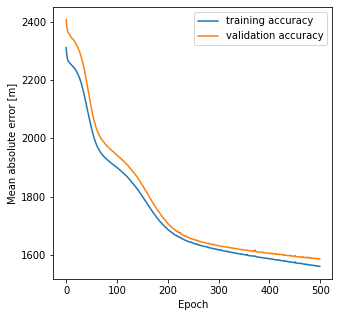

In [ ]:
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(hist.epoch, hist.history['loss'])
axs.plot(hist.epoch, hist.history['val_loss'])
axs.legend(('training loss', 'validation loss'), loc='best')
#axs[1].plot(hist.epoch, hist.history['accuracy'])
#axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs.set_ylabel('Mean absolute error [m]')
axs.set_xlabel('Epoch')
axs.legend(('training accuracy', 'validation accuracy'), loc='best')
plt.savefig('/content/drive/MyDrive/ML_project/training_batchSize_'+str(batch_size)+'_learningRate_'+str(learning_rate)+'.png', dpi=75)
plt.show()

store history to create plot with different test in one figure

In [ ]:
#### save history 
#testing = {} #run only after first testing run
testing['LR_'+str(learning_rate)] = hist.history
print(testing.keys())

dict_keys(['LR_0.01', 'LR_0.001', 'LR_0.0001'])


visualize different test in one figure

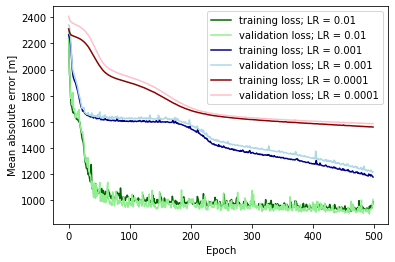

In [ ]:
# test different learning rates
fs = 10
fig, axs = plt.subplots() #figsize=(,10))
for lr,col1,col2 in zip([0.01, 0.001, 0.0001],['darkgreen','darkblue','darkred'],['lightgreen','lightblue','pink']):
  axs.plot(hist.epoch, testing['LR_'+str(lr)]['loss'], label='training loss; LR = '+str(lr), color=col1)
  axs.plot(hist.epoch, testing['LR_'+str(lr)]['val_loss'], label='validation loss; LR = '+str(lr), color=col2)
axs.legend(loc='best',fontsize=fs)
axs.set_ylabel('Mean absolute error [m]',fontsize=fs)
axs.set_xlabel('Epoch',fontsize=fs)
plt.savefig('/content/drive/MyDrive/ML_project/training_batchSize_'+str(batch_size)+'_testing-learningRate.png', dpi=300)
plt.show()

#### Project in progress!
To obtain the best model, we will continue testing different:
* model (number of hidden layers, width of hidden layers) 
* batch sizes
* epochs

